# DataExtraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn import metrics

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaCMATERdb/BanglaCharacterDataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/201/bcc000060.bmp  
  inflating: Dataset/Train/201/bcc000061.bmp  
  inflating: Dataset/Train/201/bcc000062.bmp  
  inflating: Dataset/Train/201/bcc000063.bmp  
  inflating: Dataset/Train/201/bcc000064.bmp  
  inflating: Dataset/Train/201/bcc000065.bmp  
  inflating: Dataset/Train/201/bcc000066.bmp  
  inflating: Dataset/Train/201/bcc000067.bmp  
  inflating: Dataset/Train/201/bcc000068.bmp  
  inflating: Dataset/Train/201/bcc000069.bmp  
  inflating: Dataset/Train/201/bcc000070.bmp  
  inflating: Dataset/Train/201/bcc000071.bmp  
  inflating: Dataset/Train/201/bcc000072.bmp  
  inflating: Dataset/Train/201/bcc000073.bmp  
  inflating: Dataset/Train/201/bcc000074.bmp  
  inflating: Dataset/Train/201/bcc000075.bmp  
  inflating: Dataset/Train/201/bcc000076.bmp  
  inflating: Dataset/Train/201/bcc000077.bmp  
  inflating: Dataset/Train/201/bcc000078.bmp  
  inflating: Dataset/Train/201/bcc000079.bmp  
  inflati

# After Extraction

In [ ]:
ROOT_DIR = '/content/Dataset'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))

In [ ]:
paths = glob.glob('/content/Dataset/*/*/*.bmp')

df = pd.DataFrame({'Path': paths})

def extract_label(path):
    return int(path.split('/')[-2])

def extract_set(path):
    return path.split('/')[-3]

df['Label'] = df['Path'].apply(extract_label)
# df = pd.concat([df, pd.get_dummies(df['Label'])], axis = 1)

df['Set'] = df['Path'].apply(extract_set)

# train_df = df.loc[df['Set'] == 'Train'].iloc[:, :-1]
# test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

train_df = df.loc[df['Label'] >= 183].iloc[:, :-1]
test_df = df.loc[df['Label'] < 183].iloc[:, :-1]

In [ ]:
df

,Path,Label,Set
0,/content/Dataset/Test/219/bcc000028.bmp,219,Test
1,/content/Dataset/Test/219/bcc000013.bmp,219,Test
2,/content/Dataset/Test/219/bcc000008.bmp,219,Test
3,/content/Dataset/Test/219/bcc000017.bmp,219,Test
4,/content/Dataset/Test/219/bcc000052.bmp,219,Test
...,...,...,...
14995,/content/Dataset/Train/175/bcc000068.bmp,175,Train
14996,/content/Dataset/Train/175/bcc000082.bmp,175,Train
14997,/content/Dataset/Train/175/bcc000088.bmp,175,Train
14998,/content/Dataset/Train/175/bcc000177.bmp,175,Train


In [ ]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis = 1)
train_df = train_df.reset_index(drop=True)
train_df

,Path,Label,183,184,185,186,187,188,189,190,...,212,213,214,215,216,217,218,219,220,221
0,/content/Dataset/Test/219/bcc000028.bmp,219,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,/content/Dataset/Test/219/bcc000013.bmp,219,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,/content/Dataset/Test/219/bcc000008.bmp,219,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,/content/Dataset/Test/219/bcc000017.bmp,219,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,/content/Dataset/Test/219/bcc000052.bmp,219,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11695,/content/Dataset/Train/185/bcc000068.bmp,185,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11696,/content/Dataset/Train/185/bcc000082.bmp,185,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11697,/content/Dataset/Train/185/bcc000088.bmp,185,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11698,/content/Dataset/Train/185/bcc000177.bmp,185,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis = 1)
test_df = test_df.reset_index(drop=True)
test_df

,Path,Label,172,173,174,175,176,177,178,179,180,181,182
0,/content/Dataset/Test/182/bcc000028.bmp,182,0,0,0,0,0,0,0,0,0,0,1
1,/content/Dataset/Test/182/bcc000013.bmp,182,0,0,0,0,0,0,0,0,0,0,1
2,/content/Dataset/Test/182/bcc000008.bmp,182,0,0,0,0,0,0,0,0,0,0,1
3,/content/Dataset/Test/182/bcc000017.bmp,182,0,0,0,0,0,0,0,0,0,0,1
4,/content/Dataset/Test/182/bcc000052.bmp,182,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,/content/Dataset/Train/175/bcc000068.bmp,175,0,0,0,1,0,0,0,0,0,0,0
3296,/content/Dataset/Train/175/bcc000082.bmp,175,0,0,0,1,0,0,0,0,0,0,0
3297,/content/Dataset/Train/175/bcc000088.bmp,175,0,0,0,1,0,0,0,0,0,0,0
3298,/content/Dataset/Train/175/bcc000177.bmp,175,0,0,0,1,0,0,0,0,0,0,0


(68, 112, 3)


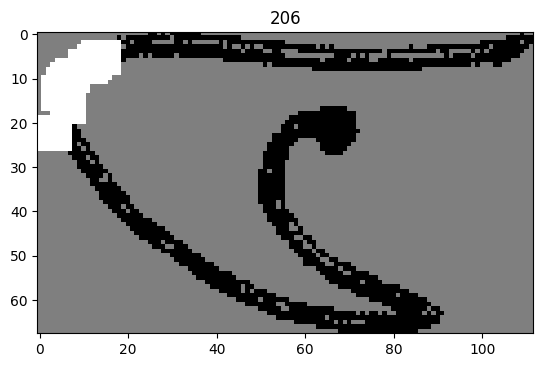

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

In [ ]:
class CustomDatasetLoader(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)

        if self.transform:
            img = self.transform(img)

        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    # torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
# all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
# all_data_loader = torch.utils.data.DataLoader(
#     dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
# )

In [ ]:
for (images, labels) in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32, 39])


In [ ]:
for (images, labels) in test_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64, 11])


# Pipeline

In [ ]:
def train(model, dataloader, embedding, criterion, optimizer, device):
    model.train()

    train_count, correct_predictions, train_loss = 0, 0, 0

    for (images, labels) in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        # _, labels = torch.max(labels.data, 1)

        predictions = model(images)
        predictions = torch.matmul(predictions.to(float), embedding)

        optimizer.zero_grad()
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(predictions.data, 1)
        _, labels = torch.max(labels.data, 1)

        train_count += labels.shape[0]
        correct_predictions += (predictions == labels).sum().item()
        train_loss += loss.item()

    train_acc = correct_predictions / train_count
    train_loss = train_loss / len(dataloader)

    return train_acc, train_loss

In [ ]:
def test(model, dataloader, embedding, criterion, device):
    model.eval()
    test_loss, test_count, correct_predictions = 0, 0, 0

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            predictions = torch.matmul(predictions.to(float), embedding)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            test_count += labels.shape[0]
            correct_predictions += (predictions == labels).sum().item()

        test_acc = correct_predictions / test_count
        test_loss = test_loss / len(dataloader)

    return test_acc, test_loss

In [ ]:
def eval_report(model, dataloader, embedding, device):
    model.eval()
    # test_count, correct_predictions = 0, 0

    preds, actuals = [], []

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            predictions = torch.matmul(predictions.to(float), embedding)

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            for i in range(len(predictions)):
                preds.append(predictions[i].item())
                actuals.append(labels[i].item())

            # test_count += labels.shape[0]
            # correct_predictions += (predictions == labels).sum().item()

        # test_acc = correct_predictions / test_count

    # preds = torch.flatten(preds)
    # actuals = torch.flatten(actuals)

    acc = metrics.accuracy_score(y_true=actuals, y_pred=preds)
    pr = metrics.precision_score(y_true=actuals, y_pred=preds, average='micro')
    re = metrics.recall_score(y_true=actuals, y_pred=preds, average='micro')
    f1 = metrics.f1_score(y_true=actuals, y_pred=preds, average='micro')

    print(f"\nAccuracy : {acc*100:.2f}%")
    print(f"Precision: {pr:.4f}")
    print(f"Recall   : {re:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # return test_acc
    return preds, actuals

# Model

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, n_features=64, dropout=0.0):
        super(CustomCNN, self).__init__()
        self.relu = nn.ReLU()
        self.maxpool_k2xs1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        self.maxpool_k2xs2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv_dropout = nn.Dropout2d(p=dropout)
        self.fc_dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=(1, 1), padding=0)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=n_features)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.batch_norm5 = nn.BatchNorm2d(256)

    def forward(self, img):
        img = self.conv_dropout(self.batch_norm1(self.maxpool_k2xs1(self.relu(self.conv1(img)))))
        img = self.conv_dropout(self.batch_norm2(self.maxpool_k2xs2(self.relu(self.conv2(img)))))
        img = self.conv_dropout(self.batch_norm3(self.maxpool_k2xs2(self.relu(self.conv3(img)))))
        img = self.conv_dropout(self.batch_norm4(self.maxpool_k2xs2(self.relu(self.conv4(img)))))
        img = self.conv_dropout(self.batch_norm5(self.relu(self.conv5(img))))
        img = img.reshape(img.shape[0], -1)
        img = self.fc_dropout(self.relu(self.fc1(img)))
        img = self.fc_dropout(self.relu(self.fc2(img)))
        img = self.out(img)
        return img

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)

sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

# Train-Validation-Test

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaCMATERdb/Embd_VAEResnet/embd_all_images_avg_df.csv')

test_embedding = embedding.iloc[:, :11].values  # (64, 11)
train_embedding = embedding.iloc[:, 11:].values  # (64, 39)

train_embedding = torch.from_numpy(train_embedding)
test_embedding = torch.from_numpy(test_embedding)

train_embedding = train_embedding.to(DEVICE)
test_embedding = test_embedding.to(DEVICE)

train_embedding.shape, test_embedding.shape

(torch.Size([64, 39]), torch.Size([64, 11]))

In [ ]:
# embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images_avg_df.csv')

# embedding = embedding.iloc[:, :].values
# # embedding = embedding.iloc[:, :].values.T
# embedding = torch.from_numpy(embedding)
# embedding = embedding.to(DEVICE)
# embedding.shape, embedding

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(100+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, train_embedding, criterion, optimizer, DEVICE)
    test_acc, test_loss = test(model, test_loader, test_embedding, criterion, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%, Test Loss: {test_loss:.4f}\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if test_loss < best_loss and epoch != 0:
        best_acc = test_acc
        best_loss = test_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 52/52 [00:02<00:00, 22.84it/s]


Training Accuracy: 65.334%, Training Loss: 1.1603, Test Accuracy: 40.212%, Test Loss: 2.9462

Epoch: 1


100%|██████████| 52/52 [00:02<00:00, 23.16it/s]


Training Accuracy: 85.625%, Training Loss: 0.4670, Test Accuracy: 31.879%, Test Loss: 4.0208

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 52/52 [00:02<00:00, 23.38it/s]


Training Accuracy: 90.214%, Training Loss: 0.3113, Test Accuracy: 40.333%, Test Loss: 3.5160

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 52/52 [00:02<00:00, 22.86it/s]


Training Accuracy: 92.038%, Training Loss: 0.2528, Test Accuracy: 38.424%, Test Loss: 3.5402

Epoch: 4


100%|██████████| 52/52 [00:02<00:00, 23.46it/s]


Training Accuracy: 93.827%, Training Loss: 0.1937, Test Accuracy: 37.424%, Test Loss: 4.8408

Epoch: 5


100%|██████████| 52/52 [00:02<00:00, 22.71it/s]


Training Accuracy: 94.752%, Training Loss: 0.1671, Test Accuracy: 42.000%, Test Loss: 3.2898

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 52/52 [00:02<00:00, 22.64it/s]


Training Accuracy: 95.180%, Training Loss: 0.1538, Test Accuracy: 40.606%, Test Loss: 3.8673

Epoch: 7


100%|██████████| 52/52 [00:02<00:00, 20.65it/s]


Training Accuracy: 96.575%, Training Loss: 0.1076, Test Accuracy: 43.182%, Test Loss: 3.6985

Epoch: 8


100%|██████████| 52/52 [00:03<00:00, 17.04it/s]


Training Accuracy: 96.070%, Training Loss: 0.1239, Test Accuracy: 40.576%, Test Loss: 3.7623

Epoch: 9


100%|██████████| 52/52 [00:03<00:00, 17.10it/s]


Training Accuracy: 96.413%, Training Loss: 0.1171, Test Accuracy: 34.455%, Test Loss: 6.4344

Epoch: 10


100%|██████████| 52/52 [00:02<00:00, 20.70it/s]


Training Accuracy: 96.781%, Training Loss: 0.1082, Test Accuracy: 27.667%, Test Loss: 7.6454

Epoch: 11


100%|██████████| 52/52 [00:02<00:00, 22.98it/s]


Training Accuracy: 97.149%, Training Loss: 0.0929, Test Accuracy: 42.121%, Test Loss: 3.9462

Epoch: 12


100%|██████████| 52/52 [00:02<00:00, 22.59it/s]


Training Accuracy: 96.832%, Training Loss: 0.1119, Test Accuracy: 39.333%, Test Loss: 4.4859

Epoch: 13


100%|██████████| 52/52 [00:02<00:00, 22.67it/s]


Training Accuracy: 97.149%, Training Loss: 0.0875, Test Accuracy: 35.121%, Test Loss: 6.0373

Epoch: 14


100%|██████████| 52/52 [00:02<00:00, 22.72it/s]


Training Accuracy: 97.988%, Training Loss: 0.0695, Test Accuracy: 35.242%, Test Loss: 5.9339

Epoch: 15


100%|██████████| 52/52 [00:02<00:00, 22.70it/s]


Training Accuracy: 97.346%, Training Loss: 0.0897, Test Accuracy: 36.394%, Test Loss: 4.8981

Epoch: 16


100%|██████████| 52/52 [00:02<00:00, 22.61it/s]


Training Accuracy: 98.622%, Training Loss: 0.0455, Test Accuracy: 31.515%, Test Loss: 6.5966

Epoch: 17


100%|██████████| 52/52 [00:02<00:00, 19.98it/s]


Training Accuracy: 97.997%, Training Loss: 0.0727, Test Accuracy: 36.848%, Test Loss: 4.2028

Epoch: 18


100%|██████████| 52/52 [00:03<00:00, 16.81it/s]


Training Accuracy: 97.543%, Training Loss: 0.0853, Test Accuracy: 35.939%, Test Loss: 5.0411

Epoch: 19


100%|██████████| 52/52 [00:03<00:00, 17.06it/s]


Training Accuracy: 98.142%, Training Loss: 0.0616, Test Accuracy: 37.970%, Test Loss: 5.0547

Epoch: 20


100%|██████████| 52/52 [00:02<00:00, 20.62it/s]


Training Accuracy: 98.656%, Training Loss: 0.0491, Test Accuracy: 35.242%, Test Loss: 6.1064

Epoch: 21


100%|██████████| 52/52 [00:02<00:00, 22.73it/s]


Training Accuracy: 98.108%, Training Loss: 0.0650, Test Accuracy: 35.182%, Test Loss: 5.8942

Epoch: 22


100%|██████████| 52/52 [00:02<00:00, 22.42it/s]


Training Accuracy: 98.433%, Training Loss: 0.0536, Test Accuracy: 33.121%, Test Loss: 5.0893

Epoch: 23


100%|██████████| 52/52 [00:02<00:00, 22.90it/s]


Training Accuracy: 98.579%, Training Loss: 0.0504, Test Accuracy: 31.788%, Test Loss: 6.1345

Epoch: 24


100%|██████████| 52/52 [00:02<00:00, 22.76it/s]


Training Accuracy: 98.425%, Training Loss: 0.0539, Test Accuracy: 29.545%, Test Loss: 6.2400

Epoch: 25


100%|██████████| 52/52 [00:02<00:00, 22.71it/s]


Training Accuracy: 98.519%, Training Loss: 0.0578, Test Accuracy: 27.273%, Test Loss: 5.7476

Epoch: 26


100%|██████████| 52/52 [00:02<00:00, 22.56it/s]


Training Accuracy: 98.887%, Training Loss: 0.0411, Test Accuracy: 32.273%, Test Loss: 7.0951

Epoch: 27


100%|██████████| 52/52 [00:02<00:00, 22.50it/s]


Training Accuracy: 98.382%, Training Loss: 0.0546, Test Accuracy: 29.606%, Test Loss: 6.6897

Epoch: 28


100%|██████████| 52/52 [00:02<00:00, 19.98it/s]


Training Accuracy: 98.861%, Training Loss: 0.0424, Test Accuracy: 32.364%, Test Loss: 5.9856

Epoch: 29


100%|██████████| 52/52 [00:03<00:00, 16.24it/s]


Training Accuracy: 98.159%, Training Loss: 0.0676, Test Accuracy: 34.515%, Test Loss: 5.3614

Epoch: 30


100%|██████████| 52/52 [00:03<00:00, 16.75it/s]


Training Accuracy: 98.390%, Training Loss: 0.0541, Test Accuracy: 33.455%, Test Loss: 5.5809

Epoch: 31


100%|██████████| 52/52 [00:02<00:00, 19.56it/s]


Training Accuracy: 98.861%, Training Loss: 0.0393, Test Accuracy: 33.182%, Test Loss: 5.0836

Epoch: 32


100%|██████████| 52/52 [00:02<00:00, 22.42it/s]


Training Accuracy: 98.904%, Training Loss: 0.0388, Test Accuracy: 36.030%, Test Loss: 4.3580

Epoch: 33


100%|██████████| 52/52 [00:02<00:00, 22.48it/s]


Training Accuracy: 98.913%, Training Loss: 0.0424, Test Accuracy: 33.394%, Test Loss: 6.0185

Epoch: 34


100%|██████████| 52/52 [00:02<00:00, 21.76it/s]


Training Accuracy: 98.938%, Training Loss: 0.0357, Test Accuracy: 32.273%, Test Loss: 6.7720

Epoch: 35


100%|██████████| 52/52 [00:02<00:00, 21.79it/s]


Training Accuracy: 98.938%, Training Loss: 0.0411, Test Accuracy: 27.273%, Test Loss: 6.6067

Epoch: 36


100%|██████████| 52/52 [00:02<00:00, 22.25it/s]


Training Accuracy: 98.878%, Training Loss: 0.0430, Test Accuracy: 30.576%, Test Loss: 5.7697

Epoch: 37


100%|██████████| 52/52 [00:02<00:00, 22.47it/s]


Training Accuracy: 98.750%, Training Loss: 0.0452, Test Accuracy: 30.152%, Test Loss: 5.7877

Epoch: 38


100%|██████████| 52/52 [00:02<00:00, 22.05it/s]


Training Accuracy: 98.801%, Training Loss: 0.0416, Test Accuracy: 28.939%, Test Loss: 5.6093

Epoch: 39


100%|██████████| 52/52 [00:02<00:00, 21.31it/s]


Training Accuracy: 99.195%, Training Loss: 0.0331, Test Accuracy: 32.485%, Test Loss: 4.9660

Epoch: 40


100%|██████████| 52/52 [00:02<00:00, 17.54it/s]


Training Accuracy: 98.527%, Training Loss: 0.0573, Test Accuracy: 31.606%, Test Loss: 5.9891

Epoch: 41


100%|██████████| 52/52 [00:03<00:00, 15.88it/s]


Training Accuracy: 98.844%, Training Loss: 0.0491, Test Accuracy: 26.636%, Test Loss: 6.4765

Epoch: 42


100%|██████████| 52/52 [00:02<00:00, 18.76it/s]


Training Accuracy: 99.007%, Training Loss: 0.0400, Test Accuracy: 28.879%, Test Loss: 6.1845

Epoch: 43


100%|██████████| 52/52 [00:02<00:00, 22.24it/s]


Training Accuracy: 99.212%, Training Loss: 0.0368, Test Accuracy: 28.697%, Test Loss: 6.2451

Epoch: 44


100%|██████████| 52/52 [00:02<00:00, 22.13it/s]


Training Accuracy: 99.272%, Training Loss: 0.0269, Test Accuracy: 28.000%, Test Loss: 6.3707

Epoch: 45


100%|██████████| 52/52 [00:02<00:00, 22.34it/s]


Training Accuracy: 99.101%, Training Loss: 0.0367, Test Accuracy: 32.515%, Test Loss: 5.5902

Epoch: 46


100%|██████████| 52/52 [00:02<00:00, 22.43it/s]


Training Accuracy: 99.204%, Training Loss: 0.0278, Test Accuracy: 28.121%, Test Loss: 6.4496

Epoch: 47


100%|██████████| 52/52 [00:02<00:00, 22.50it/s]


Training Accuracy: 99.512%, Training Loss: 0.0221, Test Accuracy: 25.970%, Test Loss: 7.3221

Epoch: 48


100%|██████████| 52/52 [00:02<00:00, 22.28it/s]


Training Accuracy: 99.067%, Training Loss: 0.0410, Test Accuracy: 32.515%, Test Loss: 5.9357

Epoch: 49


100%|██████████| 52/52 [00:02<00:00, 22.56it/s]


Training Accuracy: 99.144%, Training Loss: 0.0322, Test Accuracy: 30.909%, Test Loss: 6.2390

Epoch: 50


100%|██████████| 52/52 [00:02<00:00, 19.95it/s]


Training Accuracy: 99.204%, Training Loss: 0.0291, Test Accuracy: 31.485%, Test Loss: 6.3182

Epoch: 51


100%|██████████| 52/52 [00:03<00:00, 15.95it/s]


Training Accuracy: 99.264%, Training Loss: 0.0325, Test Accuracy: 31.394%, Test Loss: 6.0064

Epoch: 52


100%|██████████| 52/52 [00:03<00:00, 16.96it/s]


Training Accuracy: 99.170%, Training Loss: 0.0293, Test Accuracy: 28.667%, Test Loss: 6.4597

Epoch: 53


100%|██████████| 52/52 [00:02<00:00, 21.19it/s]


Training Accuracy: 99.067%, Training Loss: 0.0354, Test Accuracy: 28.364%, Test Loss: 6.1329

Epoch: 54


100%|██████████| 52/52 [00:02<00:00, 22.26it/s]


Training Accuracy: 98.793%, Training Loss: 0.0515, Test Accuracy: 27.545%, Test Loss: 5.4254

Epoch: 55


100%|██████████| 52/52 [00:02<00:00, 22.36it/s]


Training Accuracy: 99.229%, Training Loss: 0.0292, Test Accuracy: 31.545%, Test Loss: 5.3300

Epoch: 56


100%|██████████| 52/52 [00:02<00:00, 22.15it/s]


Training Accuracy: 99.461%, Training Loss: 0.0144, Test Accuracy: 28.485%, Test Loss: 6.2654

Epoch: 57


100%|██████████| 52/52 [00:02<00:00, 22.57it/s]


Training Accuracy: 99.238%, Training Loss: 0.0273, Test Accuracy: 36.273%, Test Loss: 4.7171

Epoch: 58


100%|██████████| 52/52 [00:02<00:00, 22.49it/s]


Training Accuracy: 99.332%, Training Loss: 0.0263, Test Accuracy: 37.273%, Test Loss: 4.7017

Epoch: 59


100%|██████████| 52/52 [00:02<00:00, 22.45it/s]


Training Accuracy: 98.955%, Training Loss: 0.0489, Test Accuracy: 32.030%, Test Loss: 5.4785

Epoch: 60


100%|██████████| 52/52 [00:02<00:00, 21.15it/s]


Training Accuracy: 98.964%, Training Loss: 0.0418, Test Accuracy: 33.091%, Test Loss: 6.0962

Epoch: 61


100%|██████████| 52/52 [00:02<00:00, 17.96it/s]


Training Accuracy: 99.478%, Training Loss: 0.0208, Test Accuracy: 31.818%, Test Loss: 5.9931

Epoch: 62


100%|██████████| 52/52 [00:03<00:00, 16.78it/s]


Training Accuracy: 99.615%, Training Loss: 0.0172, Test Accuracy: 30.182%, Test Loss: 6.3010

Epoch: 63


100%|██████████| 52/52 [00:02<00:00, 20.00it/s]


Training Accuracy: 99.478%, Training Loss: 0.0214, Test Accuracy: 27.515%, Test Loss: 6.8708

Epoch: 64


100%|██████████| 52/52 [00:02<00:00, 23.05it/s]


Training Accuracy: 99.264%, Training Loss: 0.0304, Test Accuracy: 30.212%, Test Loss: 6.4542

Epoch: 65


100%|██████████| 52/52 [00:02<00:00, 22.64it/s]


Training Accuracy: 99.358%, Training Loss: 0.0295, Test Accuracy: 29.333%, Test Loss: 6.9091

Epoch: 66


100%|██████████| 52/52 [00:02<00:00, 22.46it/s]


Training Accuracy: 99.375%, Training Loss: 0.0250, Test Accuracy: 30.576%, Test Loss: 5.9447

Epoch: 67


100%|██████████| 52/52 [00:02<00:00, 22.85it/s]


Training Accuracy: 99.426%, Training Loss: 0.0201, Test Accuracy: 29.091%, Test Loss: 6.3014

Epoch: 68


100%|██████████| 52/52 [00:02<00:00, 22.15it/s]


Training Accuracy: 99.264%, Training Loss: 0.0276, Test Accuracy: 28.848%, Test Loss: 6.8226

Epoch: 69


100%|██████████| 52/52 [00:02<00:00, 22.69it/s]


Training Accuracy: 99.349%, Training Loss: 0.0259, Test Accuracy: 30.818%, Test Loss: 7.1490

Epoch: 70


100%|██████████| 52/52 [00:02<00:00, 20.64it/s]


Training Accuracy: 99.298%, Training Loss: 0.0314, Test Accuracy: 31.242%, Test Loss: 6.6701

Epoch: 71


100%|██████████| 52/52 [00:03<00:00, 16.99it/s]


Training Accuracy: 99.144%, Training Loss: 0.0396, Test Accuracy: 26.030%, Test Loss: 8.5883

Epoch: 72


100%|██████████| 52/52 [00:02<00:00, 17.72it/s]


Training Accuracy: 99.461%, Training Loss: 0.0219, Test Accuracy: 27.424%, Test Loss: 6.6689

Epoch: 73


100%|██████████| 52/52 [00:02<00:00, 22.15it/s]


Training Accuracy: 99.529%, Training Loss: 0.0186, Test Accuracy: 30.727%, Test Loss: 6.2946

Epoch: 74


100%|██████████| 52/52 [00:02<00:00, 23.00it/s]


Training Accuracy: 99.555%, Training Loss: 0.0223, Test Accuracy: 26.030%, Test Loss: 7.3150

Epoch: 75


100%|██████████| 52/52 [00:02<00:00, 22.46it/s]


Training Accuracy: 99.384%, Training Loss: 0.0236, Test Accuracy: 27.939%, Test Loss: 6.3317

Epoch: 76


100%|██████████| 52/52 [00:02<00:00, 22.32it/s]


Training Accuracy: 99.503%, Training Loss: 0.0218, Test Accuracy: 27.879%, Test Loss: 6.0165

Epoch: 77


100%|██████████| 52/52 [00:02<00:00, 22.71it/s]


Training Accuracy: 99.546%, Training Loss: 0.0174, Test Accuracy: 32.000%, Test Loss: 5.7286

Epoch: 78


100%|██████████| 52/52 [00:02<00:00, 22.39it/s]


Training Accuracy: 99.401%, Training Loss: 0.0255, Test Accuracy: 28.818%, Test Loss: 6.3324

Epoch: 79


100%|██████████| 52/52 [00:02<00:00, 22.78it/s]


Training Accuracy: 99.503%, Training Loss: 0.0204, Test Accuracy: 29.848%, Test Loss: 6.4629

Epoch: 80


100%|██████████| 52/52 [00:02<00:00, 17.91it/s]


Training Accuracy: 99.341%, Training Loss: 0.0262, Test Accuracy: 30.576%, Test Loss: 6.4540

Epoch: 81


100%|██████████| 52/52 [00:03<00:00, 16.36it/s]


Training Accuracy: 99.512%, Training Loss: 0.0206, Test Accuracy: 26.939%, Test Loss: 7.4993

Epoch: 82


100%|██████████| 52/52 [00:02<00:00, 19.85it/s]


Training Accuracy: 99.495%, Training Loss: 0.0221, Test Accuracy: 25.727%, Test Loss: 7.7465

Epoch: 83


100%|██████████| 52/52 [00:02<00:00, 22.75it/s]


Training Accuracy: 99.469%, Training Loss: 0.0211, Test Accuracy: 28.030%, Test Loss: 7.2980

Epoch: 84


100%|██████████| 52/52 [00:02<00:00, 22.65it/s]


Training Accuracy: 99.598%, Training Loss: 0.0196, Test Accuracy: 31.758%, Test Loss: 6.1821

Epoch: 85


100%|██████████| 52/52 [00:02<00:00, 22.54it/s]


Training Accuracy: 99.409%, Training Loss: 0.0288, Test Accuracy: 26.939%, Test Loss: 7.5318

Epoch: 86


100%|██████████| 52/52 [00:02<00:00, 22.66it/s]


Training Accuracy: 99.555%, Training Loss: 0.0217, Test Accuracy: 26.152%, Test Loss: 7.4063

Epoch: 87


100%|██████████| 52/52 [00:02<00:00, 21.99it/s]


Training Accuracy: 99.418%, Training Loss: 0.0240, Test Accuracy: 26.242%, Test Loss: 6.8417

Epoch: 88


100%|██████████| 52/52 [00:02<00:00, 22.71it/s]


Training Accuracy: 99.015%, Training Loss: 0.0511, Test Accuracy: 29.121%, Test Loss: 5.1394

Epoch: 89


100%|██████████| 52/52 [00:02<00:00, 20.41it/s]


Training Accuracy: 99.349%, Training Loss: 0.0273, Test Accuracy: 29.545%, Test Loss: 5.6610

Epoch: 90


100%|██████████| 52/52 [00:03<00:00, 16.63it/s]


Training Accuracy: 99.743%, Training Loss: 0.0106, Test Accuracy: 27.455%, Test Loss: 6.6514

Epoch: 91


100%|██████████| 52/52 [00:02<00:00, 17.64it/s]


Training Accuracy: 99.743%, Training Loss: 0.0117, Test Accuracy: 27.333%, Test Loss: 6.5561

Epoch: 92


100%|██████████| 52/52 [00:02<00:00, 21.28it/s]


Training Accuracy: 99.640%, Training Loss: 0.0130, Test Accuracy: 28.303%, Test Loss: 7.6467

Epoch: 93


100%|██████████| 52/52 [00:02<00:00, 22.72it/s]


Training Accuracy: 99.084%, Training Loss: 0.0458, Test Accuracy: 29.091%, Test Loss: 5.6693

Epoch: 94


100%|██████████| 52/52 [00:02<00:00, 22.31it/s]


Training Accuracy: 99.409%, Training Loss: 0.0238, Test Accuracy: 29.727%, Test Loss: 5.0367

Epoch: 95


100%|██████████| 52/52 [00:02<00:00, 22.46it/s]


Training Accuracy: 99.640%, Training Loss: 0.0186, Test Accuracy: 28.030%, Test Loss: 7.7631

Epoch: 96


100%|██████████| 52/52 [00:02<00:00, 22.71it/s]


Training Accuracy: 99.709%, Training Loss: 0.0132, Test Accuracy: 28.424%, Test Loss: 7.3774

Epoch: 97


100%|██████████| 52/52 [00:02<00:00, 22.59it/s]


Training Accuracy: 99.392%, Training Loss: 0.0275, Test Accuracy: 31.909%, Test Loss: 6.3720

Epoch: 98


100%|██████████| 52/52 [00:02<00:00, 22.58it/s]


Training Accuracy: 99.640%, Training Loss: 0.0122, Test Accuracy: 29.667%, Test Loss: 6.9916

Epoch: 99


100%|██████████| 52/52 [00:02<00:00, 21.25it/s]


Training Accuracy: 99.743%, Training Loss: 0.0114, Test Accuracy: 34.121%, Test Loss: 7.5125

Epoch: 100


100%|██████████| 52/52 [00:02<00:00, 18.01it/s]

Training Accuracy: 99.443%, Training Loss: 0.0292, Test Accuracy: 31.273%, Test Loss: 6.7842



# Report

In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

preds, labels = eval_report(model, test_loader, test_embedding, DEVICE)

100%|██████████| 52/52 [00:02<00:00, 22.27it/s]


Accuracy : 42.00%
Precision: 0.4200
Recall   : 0.4200
F1 Score : 0.4200
